<a href="https://colab.research.google.com/github/Srinivaskolli45/s9_assignment/blob/main/s9_assignment_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Srinivaskolli45/s9_assignment.git

import sys
sys.path.append('/content/s9_assignment/')

!pip install torch-lr-finder

Cloning into 's9_assignment'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 2), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), 6.63 KiB | 1.66 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torchvision
import numpy as np
import copy
import torch.nn as nn
import albumentations as A
from torchvision import datasets
from tqdm.autonotebook import tqdm
from trainModel import fit_model

from dataLoader import AlbumentationImageDataset
from model9 import Transformer_VIT

from torch_lr_finder import LRFinder
from torchsummary import summary
import seaborn as sns

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=32



CUDA Available: True


In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

100%|██████████| 170498071/170498071 [00:05<00:00, 29336346.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Transformer_VIT().to(device)
print(summary(net, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,608
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 48, 32, 32]          13,824
       BatchNorm2d-8           [-1, 48, 32, 32]              96
              ReLU-9           [-1, 48, 32, 32]               0
        AvgPool2d-10             [-1, 48, 1, 1]               0
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
           Linear-14                   

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.66E-03


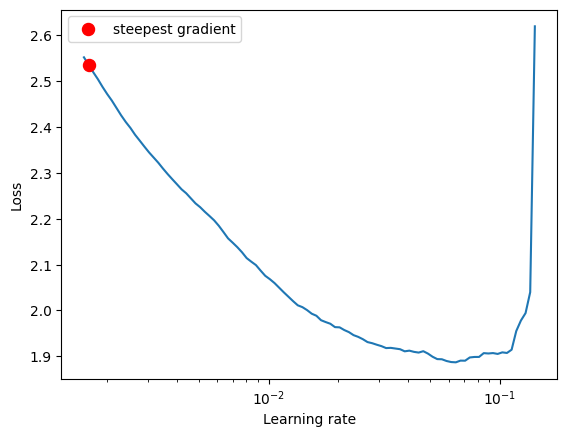

Max LR is 0.06442363508721374


In [7]:
exp_net = copy.deepcopy(net).to(device)
optimizer = torch.optim.Adam(exp_net.parameters(), lr=0.001)
criterion = nn.NLLLoss()
lr_finder = LRFinder(exp_net, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot()
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

In [8]:
train_net_1 = copy.deepcopy(net).to(device)
optimizer = torch.optim.Adam(train_net_1.parameters(), lr=(ler_rate/10))
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                )

In [9]:
train_net_1, history = fit_model(
    train_net_1, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.0064423635087213745)


Batch_id=97 Loss=1.92898 Accuracy=27.25%: 100%|██████████| 98/98 [00:17<00:00,  5.48it/s]



Test set: Average loss: 1.7396, Accuracy: 3339/10000 (33.39%)

EPOCH: 2 (LR: 0.018547528857447943)


Batch_id=97 Loss=1.68157 Accuracy=38.00%: 100%|██████████| 98/98 [00:18<00:00,  5.28it/s]



Test set: Average loss: 1.6254, Accuracy: 3999/10000 (39.99%)

EPOCH: 3 (LR: 0.030652694206174513)


Batch_id=97 Loss=1.53616 Accuracy=44.06%: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]



Test set: Average loss: 2.1336, Accuracy: 3402/10000 (34.02%)

EPOCH: 4 (LR: 0.042757859554901086)


Batch_id=97 Loss=3391.85336 Accuracy=28.57%: 100%|██████████| 98/98 [00:18<00:00,  5.37it/s]



Test set: Average loss: 15685.0694, Accuracy: 1000/10000 (10.00%)

EPOCH: 5 (LR: 0.054863024903627655)


Batch_id=97 Loss=415.81492 Accuracy=9.81%: 100%|██████████| 98/98 [00:18<00:00,  5.43it/s]



Test set: Average loss: 14.5028, Accuracy: 896/10000 (8.96%)

EPOCH: 6 (LR: 0.06371972743998212)


Batch_id=97 Loss=10.32761 Accuracy=9.99%: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]



Test set: Average loss: 7.4031, Accuracy: 1258/10000 (12.58%)

EPOCH: 7 (LR: 0.06037104057451133)


Batch_id=97 Loss=6.78378 Accuracy=10.49%: 100%|██████████| 98/98 [00:18<00:00,  5.33it/s]



Test set: Average loss: 6.9062, Accuracy: 874/10000 (8.74%)

EPOCH: 8 (LR: 0.05702235370904053)


Batch_id=97 Loss=6.56148 Accuracy=10.38%: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 6.9566, Accuracy: 831/10000 (8.31%)

EPOCH: 9 (LR: 0.05367366684356974)


Batch_id=97 Loss=5.57897 Accuracy=10.85%: 100%|██████████| 98/98 [00:18<00:00,  5.39it/s]



Test set: Average loss: 5.6857, Accuracy: 1176/10000 (11.76%)

EPOCH: 10 (LR: 0.050324979978098934)


Batch_id=97 Loss=5.25785 Accuracy=10.76%: 100%|██████████| 98/98 [00:18<00:00,  5.24it/s]



Test set: Average loss: 4.9535, Accuracy: 1270/10000 (12.70%)

EPOCH: 11 (LR: 0.04697629311262814)


Batch_id=97 Loss=5.11952 Accuracy=10.92%: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 6.1432, Accuracy: 1150/10000 (11.50%)

EPOCH: 12 (LR: 0.04362760624715734)


Batch_id=97 Loss=4.81239 Accuracy=10.53%: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s]



Test set: Average loss: 5.3420, Accuracy: 1316/10000 (13.16%)

EPOCH: 13 (LR: 0.04027891938168654)


Batch_id=97 Loss=4.19359 Accuracy=11.21%: 100%|██████████| 98/98 [00:18<00:00,  5.24it/s]



Test set: Average loss: 4.2498, Accuracy: 1129/10000 (11.29%)

EPOCH: 14 (LR: 0.036930232516215744)


Batch_id=97 Loss=4.14122 Accuracy=10.79%: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 4.4083, Accuracy: 709/10000 (7.09%)

EPOCH: 15 (LR: 0.03358154565074495)


Batch_id=97 Loss=4.12722 Accuracy=10.87%: 100%|██████████| 98/98 [00:17<00:00,  5.45it/s]



Test set: Average loss: 3.9187, Accuracy: 1315/10000 (13.15%)

EPOCH: 16 (LR: 0.030232858785274153)


Batch_id=97 Loss=3.86756 Accuracy=10.99%: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]



Test set: Average loss: 3.8015, Accuracy: 1463/10000 (14.63%)

EPOCH: 17 (LR: 0.02688417191980335)


Batch_id=97 Loss=3.72910 Accuracy=10.88%: 100%|██████████| 98/98 [00:18<00:00,  5.39it/s]



Test set: Average loss: 3.8627, Accuracy: 853/10000 (8.53%)

EPOCH: 18 (LR: 0.023535485054332554)


Batch_id=97 Loss=3.67147 Accuracy=11.21%: 100%|██████████| 98/98 [00:18<00:00,  5.35it/s]



Test set: Average loss: 3.5100, Accuracy: 1283/10000 (12.83%)

EPOCH: 19 (LR: 0.02018679818886176)


Batch_id=97 Loss=3.40604 Accuracy=11.44%: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]



Test set: Average loss: 3.3802, Accuracy: 1247/10000 (12.47%)

EPOCH: 20 (LR: 0.016838111323390956)


Batch_id=97 Loss=3.46915 Accuracy=11.01%: 100%|██████████| 98/98 [00:18<00:00,  5.39it/s]



Test set: Average loss: 3.4526, Accuracy: 1421/10000 (14.21%)

EPOCH: 21 (LR: 0.01348942445792016)


Batch_id=97 Loss=3.26566 Accuracy=10.97%: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]



Test set: Average loss: 3.4164, Accuracy: 1061/10000 (10.61%)

EPOCH: 22 (LR: 0.010140737592449364)


Batch_id=97 Loss=3.25255 Accuracy=11.02%: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]



Test set: Average loss: 3.2673, Accuracy: 1277/10000 (12.77%)

EPOCH: 23 (LR: 0.0067920507269785615)


Batch_id=97 Loss=3.28028 Accuracy=11.38%: 100%|██████████| 98/98 [00:18<00:00,  5.43it/s]



Test set: Average loss: 3.2209, Accuracy: 1282/10000 (12.82%)

EPOCH: 24 (LR: 0.0034433638615077727)


Batch_id=97 Loss=3.16229 Accuracy=11.47%: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 3.1691, Accuracy: 1226/10000 (12.26%)

